In [4]:
# ===== PROFESSIONAL PYTORCH TRAINING PIPELINE (KNEE OA KL 0–4) =====



#       INSTALL IMPORTS
!pip install kaggle timm scikit-learn --quiet
import os, zipfile, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import timm






#  DATA DOWNLOAD
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
from google.colab import files
files.upload()  # upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d shashwatwork/knee-osteoarthritis-dataset-with-severity
!unzip -q knee-osteoarthritis-dataset-with-severity.zip -d dataset




#            TRANSFORMS

DATA_DIR = "dataset"
IMG_SIZE = 160
BATCH_SIZE = 32
EPOCHS = 10
N_SPLITS = 3

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) #mean and std of imagenet
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])



# target=It extracts only the labels. use for class balancing
full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transform)
targets = full_dataset.targets
num_classes = len(full_dataset.classes)




#               CLASS WEIGHTS & CROSS VALIDATION


# skf not balance the dataset.only preserves dstrbtion.
# wc​=​N​/(K⋅nc),,rare cls msclsifid→los×6.95,maj cls→los×0.46
# enumerate() just attaches a counter to a loop.
# skf: ensures that Each fold has same % of KL 0–4.


class_weights = compute_class_weight('balanced',
                                     classes=np.unique(targets),
                                     y=targets)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    print(f"\n========== FOLD {fold+1} ==========")

    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(datasets.ImageFolder(DATA_DIR, transform=val_transform), val_idx)

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)







# mdl.clsfir[0] = dropoutlayer, mdl.clsfir[1] linear layr
# orgnl clasfir has 1k class, we have 5, so repalce 1k with num_clss

    # ================= MODEL =================
    model = models.mobilenet_v2(weights="IMAGENET1K_V1")
    for param in model.features[:-4].parameters():
        param.requires_grad = False

    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(in_features, num_classes)
    )
    model = model.to(device)






    # ================= LOSS & OPTIMIZER =================

# smothing= one-hot labels (e.g., [0,0,1,0] → [0.03,0.03,0.9,0.03])
# gradsclr=mix prcion trng; use float 16 and float 32
# Weight decay = L2 regularization.
# ReduceLROnPlateau:reduces the lrate when valid loss stops improving.
#  If metric n’t improve for 2 epochs, reduce learng rate

    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
    scaler = GradScaler()
    best_val_loss = np.inf






# model.train():on=drop out,batchNorm,, model.eval off this
# tqdm= progress bar

    #                TRAIN LOOP
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

        model.eval()
        val_loss = 0
        all_preds, all_probs, all_labels = [], [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()
                probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(probs, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        scheduler.step(val_loss)

        f1 = f1_score(all_labels, all_preds, average='weighted')
        try:
            auc = roc_auc_score(all_labels, np.array(all_probs), multi_class='ovr')
        except:
            auc = 0

        print(f"Epoch {epoch+1}: Val Loss={val_loss:.4f} F1={f1:.4f} AUC={auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"best_fold_{fold}.pth")

    fold_results.append((f1, auc))






#  FINAL RESULTS
print("\n===== CROSS-VALIDATION RESULTS =====")
for i, (f1, auc) in enumerate(fold_results):
    print(f"Fold {i+1}: F1={f1:.4f}, AUC={auc:.4f}")

print("\nMean F1:", np.mean([x[0] for x in fold_results]))
print("Mean AUC:", np.mean([x[1] for x in fold_results]))

#  TEST-TIME EVALUATION (TTA)
print("\nRunning Test-Time Augmentation...")

tta_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_dataset = datasets.ImageFolder(DATA_DIR, transform=tta_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model.load_state_dict(torch.load("best_fold_0.pth"))
model.eval()

all_preds = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())

print("Test-Time Evaluation Completed.")


Device: cuda


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/shashwatwork/knee-osteoarthritis-dataset-with-severity
License(s): Attribution 4.0 International (CC BY 4.0)
 55% 112M/204M [00:00<00:00, 1.17GB/s]
100% 204M/204M [00:00<00:00, 846MB/s] 

========== FOLD 1 ==========
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 116MB/s] 
/tmp/ipython-input-110302322.py:135: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:31<00:00,  6.52it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Val Loss=1.7113 F1=0.2080 AUC=0.0000


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:17<00:00, 11.52it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2: Val Loss=1.6464 F1=0.2312 AUC=0.0000


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:17<00:00, 11.48it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3: Val Loss=1.6648 F1=0.1022 AUC=0.0000


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:17<00:00, 11.70it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4: Val Loss=1.7050 F1=0.1269 AUC=0.0000


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:17<00:00, 11.44it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5: Val Loss=1.6811 F1=0.1185 AUC=0.0000


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:19<00:00, 10.49it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6: Val Loss=1.6411 F1=0.2011 AUC=0.5262


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:23<00:00,  8.71it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7: Val Loss=1.6439 F1=0.1601 AUC=0.5325


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:18<00:00, 10.94it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8: Val Loss=1.6385 F1=0.1800 AUC=0.0000


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:18<00:00, 10.99it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9: Val Loss=1.6491 F1=0.1555 AUC=0.5351


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:17<00:00, 11.63it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-110302322.py:135: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 10: Val Loss=1.6393 F1=0.1767 AUC=0.5337

========== FOLD 2 ==========


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:18<00:00, 11.19it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Val Loss=1.6717 F1=0.1897 AUC=0.0000


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:18<00:00, 11.21it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2: Val Loss=1.7003 F1=0.1691 AUC=0.0000


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:19<00:00, 10.69it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3: Val Loss=1.6074 F1=0.2981 AUC=0.0000


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:17<00:00, 11.44it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4: Val Loss=1.6945 F1=0.0910 AUC=0.0000


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:19<00:00, 10.72it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5: Val Loss=1.6424 F1=0.1536 AUC=0.5367


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:18<00:00, 10.94it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6: Val Loss=1.6636 F1=0.0571 AUC=0.5483


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:17<00:00, 11.34it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7: Val Loss=1.6622 F1=0.0757 AUC=0.0000


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:17<00:00, 11.58it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8: Val Loss=1.6481 F1=0.1172 AUC=0.0000


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:17<00:00, 11.41it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9: Val Loss=1.6506 F1=0.1559 AUC=0.0000


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:17<00:00, 11.38it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-110302322.py:135: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 10: Val Loss=1.6460 F1=0.1631 AUC=0.0000

========== FOLD 3 ==========


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:19<00:00, 10.63it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Val Loss=1.6511 F1=0.1883 AUC=0.0000


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:18<00:00, 11.03it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2: Val Loss=1.7588 F1=0.0770 AUC=0.0000


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:17<00:00, 11.55it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3: Val Loss=1.7010 F1=0.2020 AUC=0.0000


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:17<00:00, 11.51it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4: Val Loss=1.6971 F1=0.0989 AUC=0.0000


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:17<00:00, 11.50it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5: Val Loss=1.6597 F1=0.1404 AUC=0.5261


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:18<00:00, 11.31it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6: Val Loss=1.6475 F1=0.1896 AUC=0.5311


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:19<00:00, 10.54it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7: Val Loss=1.6598 F1=0.1750 AUC=0.5314


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:18<00:00, 10.96it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8: Val Loss=1.6576 F1=0.1730 AUC=0.5307


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:17<00:00, 11.48it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9: Val Loss=1.6484 F1=0.1995 AUC=0.5321


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipython-input-110302322.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 204/204 [00:17<00:00, 11.68it/s]
/tmp/ipython-input-110302322.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10: Val Loss=1.6542 F1=0.1857 AUC=0.5301

===== CROSS-VALIDATION RESULTS =====
Fold 1: F1=0.1767, AUC=0.5337
Fold 2: F1=0.1631, AUC=0.0000
Fold 3: F1=0.1857, AUC=0.5301

Mean F1: 0.17516110456997583
Mean AUC: 0.3545760777004691

Running Test-Time Augmentation...
Test-Time Evaluation Completed.


Detected number of classes in model: 4
Model loaded successfully.


Saving WhatsApp Image 2026-02-14 at 10.12.45 AM.jpeg to WhatsApp Image 2026-02-14 at 10.12.45 AM (1).jpeg

🦴 Predicted Knee Osteoarthritis Grade: KL3
Confidence: [0.20688465 0.22698385 0.22646068 0.3396708 ]


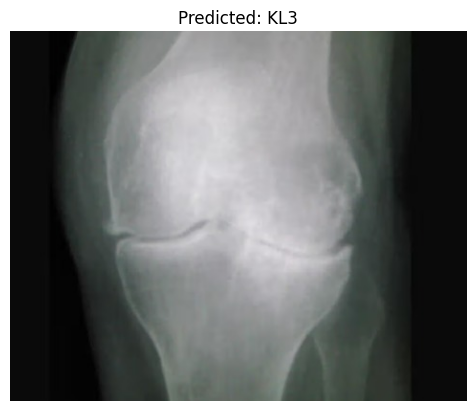

In [5]:
# ===== Cell: 2 :KNEE KL PREDICTION (AUTO-FIXED VERSION) =====

import torch
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
from torchvision import transforms, models

# -------- SETTINGS --------
IMG_SIZE = 160
MODEL_PATH = "best_fold_0.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------- LOAD CHECKPOINT FIRST --------
checkpoint = torch.load(MODEL_PATH, map_location=device)

# Automatically detect number of classes from saved model
num_classes = checkpoint["classifier.1.weight"].shape[0]

print("Detected number of classes in model:", num_classes)

# -------- REBUILD MODEL WITH CORRECT SIZE --------
model = models.mobilenet_v2(weights=None)

in_features = model.classifier[1].in_features
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.4),
    torch.nn.Linear(in_features, num_classes)
)

# Load weights
model.load_state_dict(checkpoint)
model = model.to(device)
model.eval()

print("Model loaded successfully.")

# -------- UPLOAD IMAGE --------
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# -------- TRANSFORM --------
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

img = Image.open(img_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)

# -------- PREDICT --------
with torch.no_grad():
    outputs = model(img_tensor)
    probabilities = torch.softmax(outputs, dim=1)
    pred_class = torch.argmax(probabilities, dim=1).item()

# Create labels dynamically
class_names = [f"KL{i}" for i in range(num_classes)]
pred_label = class_names[pred_class]

# -------- OUTPUT --------
print("\n🦴 Predicted Knee Osteoarthritis Grade:", pred_label)
print("Confidence:", probabilities.cpu().numpy()[0])

# -------- SHOW IMAGE --------
plt.imshow(img)
plt.title(f"Predicted: {pred_label}")
plt.axis("off")
plt.show()

Final Verified Shapes:
y_true: (3262,)
y_pred: (3262,)
y_prob: (3262, 4)


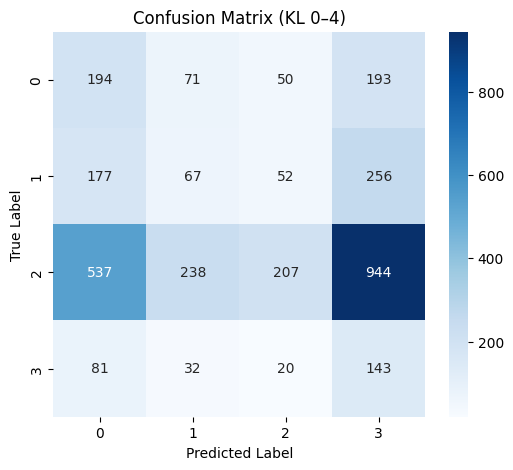


===== Classification Report =====

              precision    recall  f1-score   support

           0     0.1962    0.3819    0.2592       508
           1     0.1642    0.1214    0.1396       552
           2     0.6292    0.1075    0.1836      1926
           3     0.0931    0.5181    0.1578       276

    accuracy                         0.1873      3262
   macro avg     0.2707    0.2822    0.1850      3262
weighted avg     0.4377    0.1873    0.1857      3262



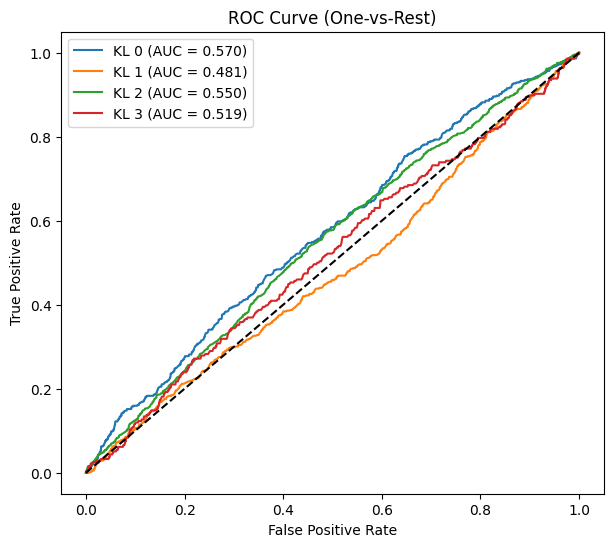


Metrics Computation Completed Successfully ✅


In [6]:
# ================= FINAL CLEAN METRICS CELL =================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# ---------- SAFELY REBUILD ARRAYS ----------
y_true = np.array(all_labels)
y_prob = np.array(all_probs)

# Recompute predictions correctly
y_pred = np.argmax(y_prob, axis=1)

print("Final Verified Shapes:")
print("y_true:", y_true.shape)
print("y_pred:", y_pred.shape)
print("y_prob:", y_prob.shape)

# ===============================
# 1️⃣ CONFUSION MATRIX
# ===============================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (KL 0–4)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ===============================
# 2️⃣ CLASSIFICATION REPORT
# ===============================
print("\n===== Classification Report =====\n")
print(classification_report(y_true, y_pred, digits=4))

# ===============================
# 3️⃣ ROC CURVE (MULTI-CLASS)
# ===============================
num_classes = y_prob.shape[1]
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

plt.figure(figsize=(7,6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"KL {i} (AUC = {roc_auc:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend()
plt.show()

print("\nMetrics Computation Completed Successfully ✅")

Model Loaded Successfully ✅


Saving WhatsApp Image 2026-02-14 at 10.12.45 AM.jpeg to WhatsApp Image 2026-02-14 at 10.12.45 AM (2).jpeg
Predicted KL Grade: 3
Confidence: 0.3397


100%|██████████| 40/40 [00:00<00:00, 48.46it/s]


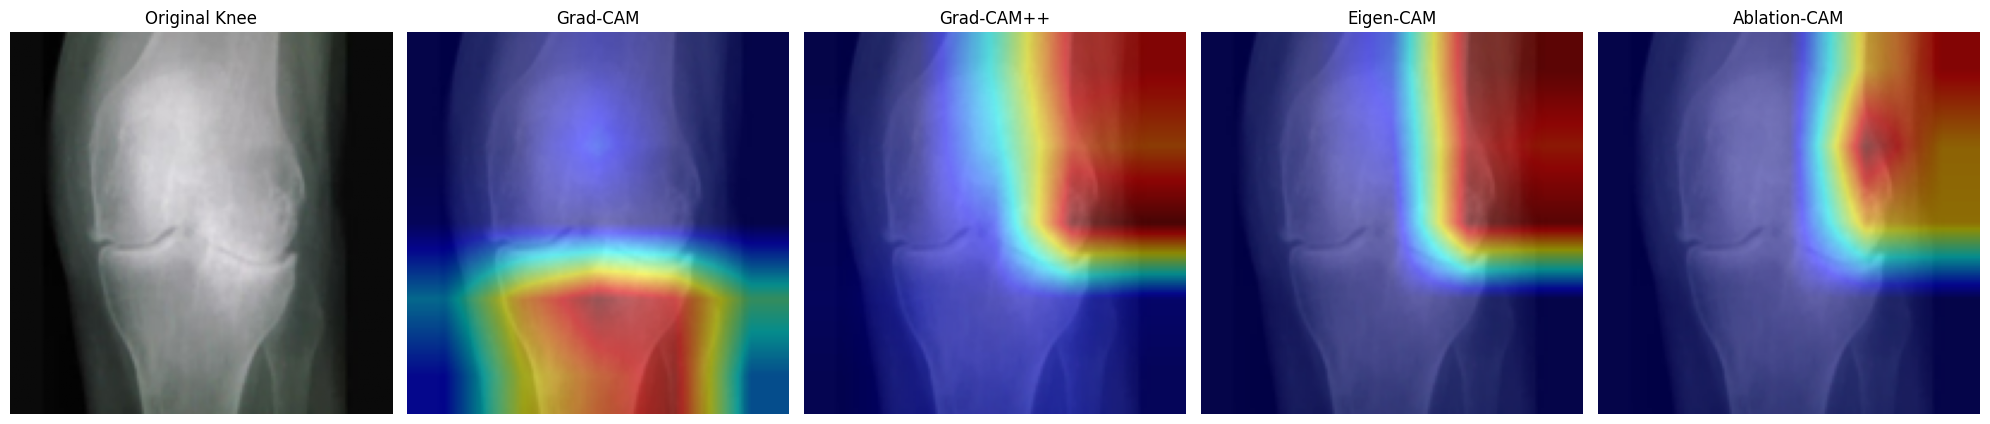

In [8]:
# XAi

# XAi

# ===================== FINAL CLEAN XAI CELL =====================

!pip install grad-cam --quiet

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torchvision import transforms, models
from google.colab import files
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM, AblationCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------- LOAD BEST MODEL --------
num_classes = 4  # KL 0–4
model = models.mobilenet_v2(weights=None)

in_features = model.classifier[1].in_features
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.4),
    torch.nn.Linear(in_features, num_classes)
)

model.load_state_dict(torch.load("best_fold_0.pth", map_location=device))
model = model.to(device)
model.eval()

print("Model Loaded Successfully ✅")

# -------- UPLOAD IMAGE FROM PC --------
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

IMG_SIZE = 160

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

img = Image.open(img_path).convert("RGB")
input_tensor = val_transform(img).unsqueeze(0).to(device)

rgb_img = np.array(img.resize((IMG_SIZE, IMG_SIZE))) / 255.0

# -------- PREDICTION --------
with torch.no_grad():
    output = model(input_tensor)
    pred_class = torch.argmax(output, dim=1).item()
    confidence = torch.softmax(output, dim=1)[0, pred_class].item()

print(f"Predicted KL Grade: {pred_class}")
print(f"Confidence: {confidence:.4f}")

target_layers = [model.features[-1]]
targets = [ClassifierOutputTarget(pred_class)]

# -------- CAM METHODS --------
cam_methods = {
    "Grad-CAM": GradCAM(model=model, target_layers=target_layers),
    "Grad-CAM++": GradCAMPlusPlus(model=model, target_layers=target_layers),
    "Eigen-CAM": EigenCAM(model=model, target_layers=target_layers),
    "Ablation-CAM": AblationCAM(model=model, target_layers=target_layers)
}

results = {}

for name, cam in cam_methods.items():
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    results[name] = visualization

# -------- DISPLAY --------
plt.figure(figsize=(20,6))

plt.subplot(1,5,1)
plt.imshow(rgb_img)
plt.title("Original Knee")
plt.axis("off")

for i,(name,vis) in enumerate(results.items()):
    plt.subplot(1,5,i+2)
    plt.imshow(vis)
    plt.title(name)
    plt.axis("off")

plt.tight_layout()
plt.show()

100%|██████████| 40/40 [00:00<00:00, 51.59it/s]


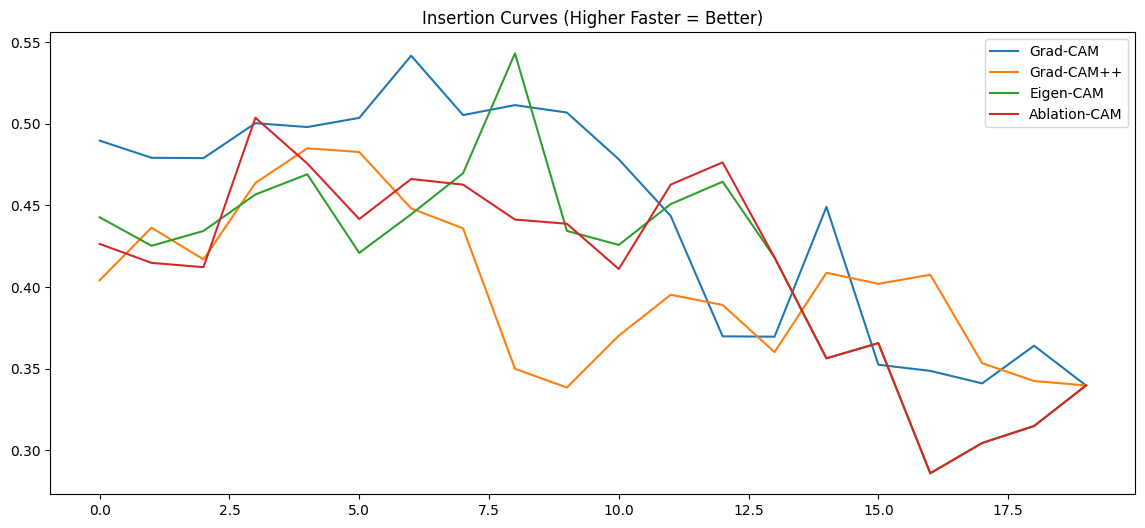

100%|██████████| 40/40 [00:00<00:00, 47.29it/s]


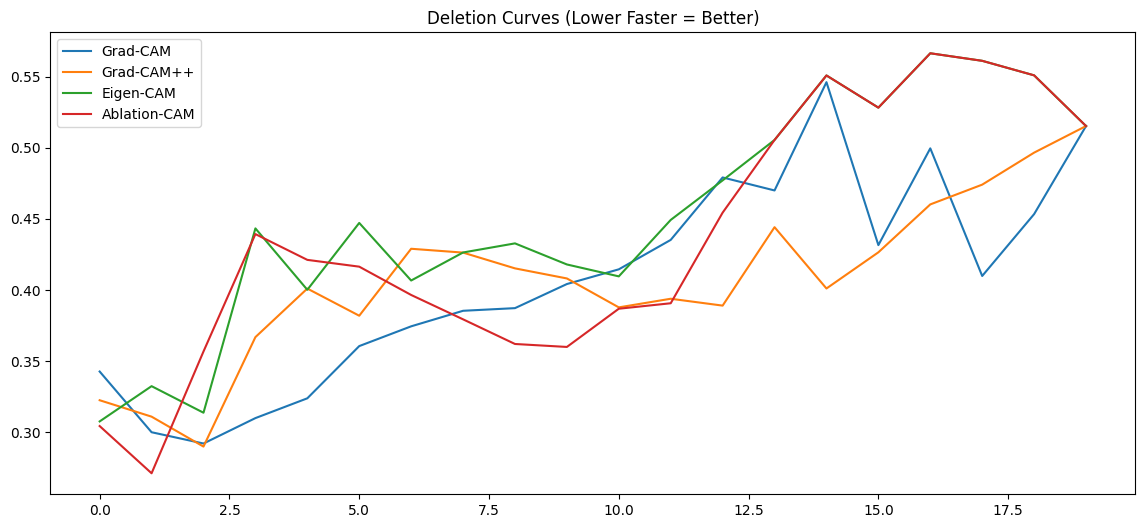


===== PROFESSIONAL XAI METRICS COMPARISON =====


,Method,Insertion AUC ↑,Deletion AUC ↓,Entropy ↓,Sparsity ↑,Intensity,Confidence Drop ↓
0,Grad-CAM,0.445025,0.405583,9.423624,0.508555,0.258020,-0.133892
1,Grad-CAM++,0.402995,0.406391,9.512612,0.568984,0.283233,-0.005893
2,Eigen-CAM,0.414463,0.454299,9.039502,0.649570,0.239763,-0.146568
3,Ablation-CAM,0.412343,0.437264,8.919216,0.688789,0.187383,-0.147729


In [9]:
# ===================== CLEAN FULL XAI METRICS CELL =====================

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import auc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def normalize_cam(cam):
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)
    return cam

def compute_entropy(cam):
    cam = cam / (cam.sum() + 1e-8)
    return -np.sum(cam * np.log(cam + 1e-8))

def compute_sparsity(cam):
    return np.sum(cam < 0.1) / cam.size

def compute_intensity(cam):
    return np.mean(cam)

def confidence_drop(model, input_tensor, cam_map):
    mask = torch.tensor(cam_map).unsqueeze(0).unsqueeze(0).to(device)
    mask = F.interpolate(mask, size=(IMG_SIZE, IMG_SIZE), mode='bilinear')

    with torch.no_grad():
        original_out = model(input_tensor)
        original_conf = F.softmax(original_out, dim=1)[0, pred_class].item()

        masked_input = input_tensor * mask
        masked_out = model(masked_input)
        masked_conf = F.softmax(masked_out, dim=1)[0, pred_class].item()

    return original_conf - masked_conf

def insertion_deletion_auc(model, input_tensor, cam_map, steps=20):
    cam_flat = cam_map.flatten()
    sorted_idx = np.argsort(-cam_flat)

    scores_insert, scores_delete = [], []

    for i in range(steps):
        percent = int(len(sorted_idx)*(i+1)/steps)
        mask = np.zeros_like(cam_flat)
        mask[sorted_idx[:percent]] = 1
        mask = mask.reshape(cam_map.shape)

        mask_tensor = torch.tensor(mask).unsqueeze(0).unsqueeze(0).to(device)
        mask_tensor = F.interpolate(mask_tensor, size=(IMG_SIZE, IMG_SIZE), mode='bilinear')

        with torch.no_grad():
            ins_out = model(input_tensor * mask_tensor)
            del_out = model(input_tensor * (1-mask_tensor))

        ins_score = F.softmax(ins_out, dim=1)[0, pred_class].item()
        del_score = F.softmax(del_out, dim=1)[0, pred_class].item()

        scores_insert.append(ins_score)
        scores_delete.append(del_score)

    x_axis = np.linspace(0,1,steps)
    ins_auc = auc(x_axis, scores_insert)
    del_auc = auc(x_axis, scores_delete)

    return ins_auc, del_auc, scores_insert, scores_delete

# ===================== METRIC COMPUTATION =====================

results_table = []

plt.figure(figsize=(14,6))

for name, cam in cam_methods.items():
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    grayscale_cam = normalize_cam(grayscale_cam)

    entropy = compute_entropy(grayscale_cam)
    sparsity = compute_sparsity(grayscale_cam)
    intensity = compute_intensity(grayscale_cam)
    conf_drop = confidence_drop(model, input_tensor, grayscale_cam)

    ins_auc, del_auc, ins_curve, del_curve = insertion_deletion_auc(
        model, input_tensor, grayscale_cam)

    results_table.append([
        name, ins_auc, del_auc,
        entropy, sparsity,
        intensity, conf_drop
    ])

    plt.plot(ins_curve, label=f"{name}")

plt.title("Insertion Curves (Higher Faster = Better)")
plt.legend()
plt.show()

plt.figure(figsize=(14,6))

for name, cam in cam_methods.items():
    grayscale_cam = normalize_cam(cam(input_tensor=input_tensor, targets=targets)[0])
    _, _, _, del_curve = insertion_deletion_auc(model, input_tensor, grayscale_cam)
    plt.plot(del_curve, label=f"{name}")

plt.title("Deletion Curves (Lower Faster = Better)")
plt.legend()
plt.show()

# ===================== RESULTS TABLE =====================

columns = [
    "Method",
    "Insertion AUC ↑",
    "Deletion AUC ↓",
    "Entropy ↓",
    "Sparsity ↑",
    "Intensity",
    "Confidence Drop ↓"
]

df_results = pd.DataFrame(results_table, columns=columns)

print("\n===== PROFESSIONAL XAI METRICS COMPARISON =====")
display(df_results)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 199MB/s]


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 122MB/s]


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 120MB/s]



🚀 Training ResNet18
ResNet18 Accuracy: 0.6110
ResNet18 F1 Score: 0.5005

🚀 Training DenseNet121
DenseNet121 Accuracy: 0.6079
DenseNet121 F1 Score: 0.4934

🚀 Training EfficientNetB0
EfficientNetB0 Accuracy: 0.5907
EfficientNetB0 F1 Score: 0.4461

📊 Model Comparison:
                Accuracy  F1 Score
ResNet18        0.610975  0.500546
DenseNet121     0.607909  0.493421
EfficientNetB0  0.590742  0.446136


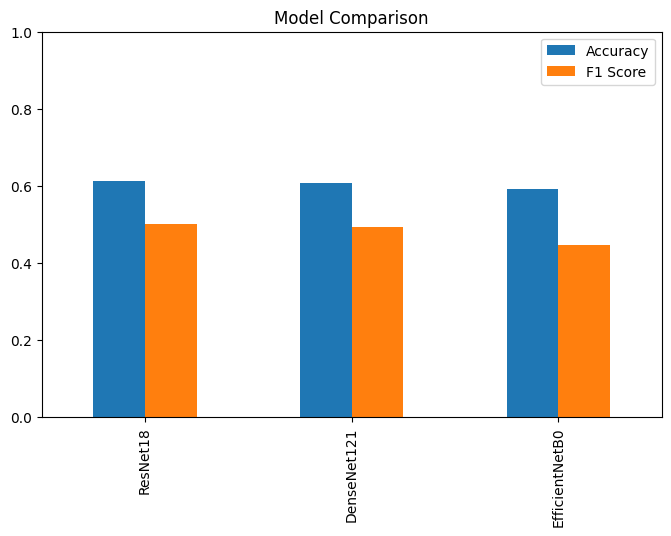

In [10]:
# ===== PYTORCH MODEL COMPARISON (USING YOUR EXISTING DATASET) =====

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = len(full_dataset.classes)
EPOCHS = 5

results = {}

models_dict = {
    "ResNet18": models.resnet18(weights="IMAGENET1K_V1"),
    "DenseNet121": models.densenet121(weights="IMAGENET1K_V1"),
    "EfficientNetB0": models.efficientnet_b0(weights="IMAGENET1K_V1")
}

for name, model in models_dict.items():
    print(f"\n🚀 Training {name}")

    # ----- Replace Final Layer -----
    if "resnet" in name.lower():
        model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif "densenet" in name.lower():
        model.classifier = nn.Linear(model.classifier.in_features, NUM_CLASSES)
    elif "efficientnet" in name.lower():
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # ----- Training -----
    model.train()
    for epoch in range(EPOCHS):
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # ----- Evaluation -----
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            y_pred.extend(preds)
            y_true.extend(labels.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    acc = np.mean(y_true == y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")

    results[name] = {"Accuracy": acc, "F1 Score": f1}

    print(f"{name} Accuracy: {acc:.4f}")
    print(f"{name} F1 Score: {f1:.4f}")

# ----- Results Table -----
results_df = pd.DataFrame(results).T
print("\n📊 Model Comparison:")
print(results_df)

results_df.plot(kind="bar", figsize=(8,5))
plt.title("Model Comparison")
plt.ylim(0,1)
plt.show()

In [13]:
from google.colab import drive
drive.mount('/content/drive')


import torch
from datetime import datetime

CHECKPOINT_PATH = "/content/drive/MyDrive/knee_OA_full_checkpoint.pth"

checkpoint = {
    "model_architecture": "mobilenet_v2",
    "num_classes": num_classes,
    "img_size": IMG_SIZE,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "scheduler_state_dict": scheduler.state_dict(),
    "class_names": full_dataset.classes,
    "fold_results": fold_results,
    "epochs_trained": EPOCHS,
    "date_saved": str(datetime.now())
}

torch.save(checkpoint, CHECKPOINT_PATH)

print("Full training checkpoint saved successfully ✅")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Full training checkpoint saved successfully ✅


In [16]:
from google.colab import drive
drive.mount('/content/drive')

import torch

SAVE_PATH = "/content/drive/MyDrive/knee_OA_model_weights.pth"

# Save only model parameters (NOT full checkpoint)
torch.save(model.state_dict(), SAVE_PATH)

print("Model weights saved successfully ✅")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model weights saved successfully ✅


In [17]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
from torchvision import models

LOAD_PATH = "/content/drive/MyDrive/knee_OA_model_weights.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate EXACT same model architecture
model = models.mobilenet_v2(weights="IMAGENET1K_V1")  # use same as training

in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(in_features, num_classes)  # same num_classes as training
)

# Load weights
model.load_state_dict(torch.load(LOAD_PATH, map_location=device))

model = model.to(device)
model.eval()

print("Model loaded successfully ✅")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model loaded successfully ✅
